# A notebook to carry out calculations

In [1]:
import sympy as sym
import scipy as sp
import numpy as np
sym.init_printing()

import imp
tools = imp.load_source('tools', '../tools.py')

assert sym.__version__ == "1.0"
assert sp.__version__ == "0.19.0"
assert np.__version__ == "1.12.1"

In [2]:
#import matplotlib
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

font = {'size'   : 15,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [3]:
from scipy.optimize import brentq
from scipy.integrate import odeint

Defining all our variables (with assumption that they are positive).

In [4]:
r, s, x, theta_r, alpha, H, beta, gamma, F = sym.symbols("r, s, x, theta_r, alpha, \
                                                          H, beta, gamma, F", positive=True)

The model
----------

In [9]:
# the theta function
tools.theta(r, s)

In [10]:
# the psi function
tools.psi(r, s)

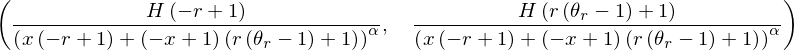

In [11]:
# gain
tools.gain(1), tools.gain(0)

In [12]:
rs = np.linspace(0, 0.999, 100)

In [13]:
gain = sym.lambdify((H, r, theta_r, s, alpha), 
                    H * tools.theta(r=r, s=s, theta_r=theta_r) ** -alpha)

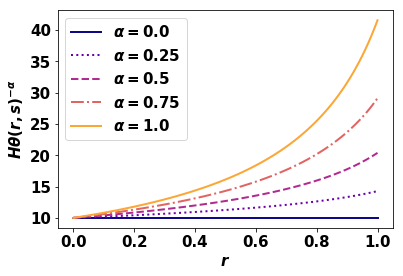

In [14]:
fig =  plt.figure();     
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-']
for i, alphas in enumerate(np.linspace(0, 1, 5)):
    ys = [gain(10, rval, 0.3, 0.2, alphas) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\alpha={}$'.format(alphas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$H\theta(r, s)^{-\alpha}$')
plt.xlabel(r'$r$')

plt.legend()
plt.savefig('../images/gain_curve.pdf', bbox_inches='tight')

In [15]:
cost = sym.lambdify((F, s, gamma, beta, r), F * (1 - r * s) ** gamma * (1 - r) ** beta)

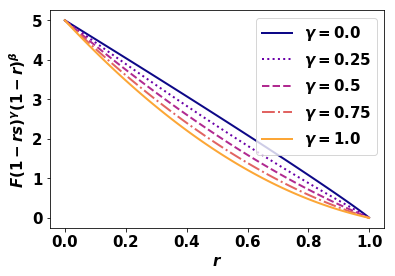

In [16]:
fig =  plt.figure()    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-']
for i, gammas in enumerate(np.linspace(0, 1, 5)):
    ys = [cost(5, 0.7, gammas, 0.95, rval) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\gamma={}$'.format(gammas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$F (1 - rs) ^{\gamma} (1 - r) ^{\beta}$')
plt.xlabel(r'$r$')
    
plt.legend()
plt.savefig('../images/gammas_curve.pdf', bbox_inches='tight')

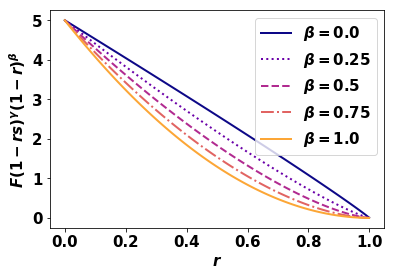

In [17]:
fig =  plt.figure()    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-']
for i, betas in enumerate(np.linspace(0, 1, 5)):
    ys = [cost(5, 1, 0.95, betas, rval) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\beta={}$'.format(betas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$F (1 - rs) ^{\gamma} (1 - r) ^{\beta}$')
plt.xlabel(r'$r$')
    
plt.legend()
plt.savefig('../images/betas_curve.pdf', bbox_inches='tight')

Utility
-------

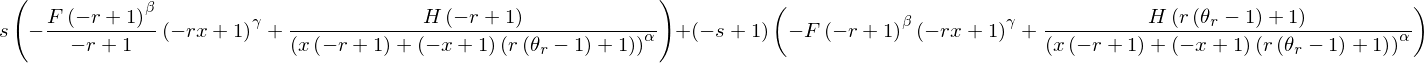

In [18]:
tools.utility()

In [19]:
expr = H * (theta_r * r * (1 - s) - r + 1) * tools.theta(r, x) ** (-alpha) - \
       F * (1 - r * x) ** gamma * ((1 - r) ** beta * (-s + s/(1 -r) + 1))

In [20]:
(tools.utility() - expr).simplify()

# Condition for $s=1$ to be stable:

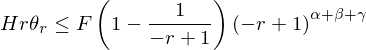

In [21]:
tools.stable_selective_condition()

In [22]:
selective_inequality = sym.lambdify((r, alpha, beta, gamma), (1 - r) ** (alpha + beta + gamma) * (1 - (1 - r) ** -1) )

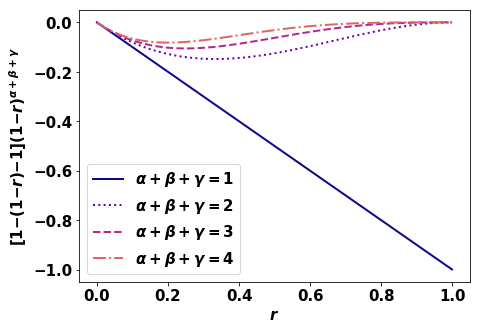

In [23]:
fig =  plt.figure(figsize=(7, 5))    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-', ':']
for i, val in enumerate([(1, 0, 0), (2, 1, 0), (3, 1, 0), (4, 1, 0)]):
    alphas, betas, gammas = val
    ys = [selective_inequality(rval, alphas, betas, gammas) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\alpha + \beta + \gamma={}$'.format(alphas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$[1 − (1 − r) − 1](1 − r)^{\alpha + \beta + \gamma}$')
plt.xlabel(r'$r$')
    
plt.legend()
plt.savefig('../images/SelectiveInequality.pdf',bbox_inches='tight')

Being selective is not stable. Because the lefh hand size is always negative and the right hand side is always
positive. Thus the condition rhs < lhs does not hold.

# Condition for $s=0$ to be stable:

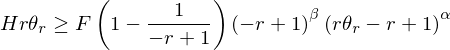

In [24]:
tools.stable_indiscriminate_condition()

In [25]:
indiscriminate__inequality = sym.lambdify((r, theta_r, alpha, beta),
                                          (1 - (1 - r) ** -1) * (1 - r) ** (beta) * (theta_r * r - r + 1) ** (alpha))

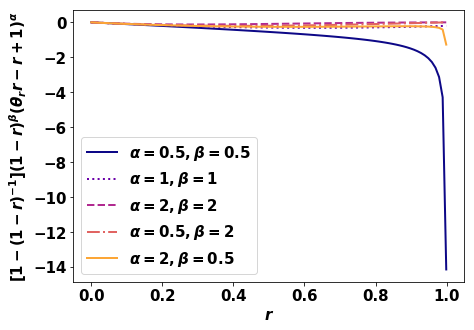

In [26]:
fig =  plt.figure(figsize=(7, 5))    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-', ':']
for i, val in enumerate([(0.5, 0.5), (1, 1), (2, 2), (0.5, 2), (2, 0.5)]):
    alphas, betas = val
    ys = [indiscriminate__inequality(rval, 0.2, alphas, betas) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\alpha={}, \beta={}$'.format(alphas, betas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$[1 - (1 - r)^{-1}](1 - r)^{\beta}(\theta_r r - r + 1)^{\alpha}$')
plt.xlabel(r'$r$')
    
plt.legend()
plt.savefig('../images/IndiscriminateInequality.pdf', bbox_inches='tight')

Being indiscriminate is always stable. left hand side is once again always negative and the right hand side is
also positive. Thus the condition rhs > lhs holds.

# Condition for $1>s^*>0$ to be stable:

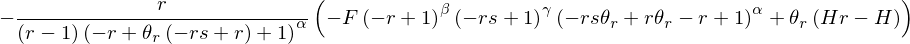

In [27]:
tools.stable_mixed_condition()

In [28]:
number_steps = 5

In [29]:
theta_rs = np.linspace(0, 1 - 0.0001, 5)
Hs = np.linspace(1, 500, number_steps)          
Fs = np.linspace(1, 50, number_steps)           
gammas = np.linspace(1, 3, number_steps)        
alphas = np.linspace(0, 2, number_steps)        
betas = np.linspace(0, 2, number_steps)  
rs = np.linspace(0, 1 - 0.0001, 10)

In [ ]:
for params in itertools.product(Fs, Hs, alphas, betas, gammas, theta_rs):
    F_v, H_v, alpha_v, beta_v, gamma_v, theta_r_v = params


    s_stars = [tools.s_star_v_r(gamma_num=gamma_v, beta_num=beta_v, theta_r_num=theta_r_v, H_num=H_v,
                                F_num=F_v) for r in rs]
    plt.plot(rs, s_stars)
    plt.savefig('~/images/mixed/{}.pdf'.format(params))

With a quick search there does not seem to be any mixed stable strategies. This will be explored more using 
the parameters sweep.

# Evolutionary stability

An ESS, is a strategy that will remain the best response even in a mutated population. A mutated
population  is the post entry population $\chi_{\epsilon}$, where
a small proportion $\epsilon$ start playing a different strategy.  Let a strategy $s^*$ 
be stable and let the mutation population be $s = s^* \pm \epsilon$,

$$u((s^*, 1 - s^*), (s, 1 -s)) > u((s, 1 - s), (s, 1 -s))  \mbox{ for all }  0 < \epsilon < \bar{\epsilon}.$$

Let, 

$$\delta_{\pm} = u((s^*, 1 - s^*), (s, 1 -s)) - u((s, 1 - s), (s, 1 -s)),$$

if there exists an $\epsilon$ for which  is $\delta_{\pm}$
smaller than a given tolerance $t$, where $t$ tend to zero, $s^*$ is ESS.


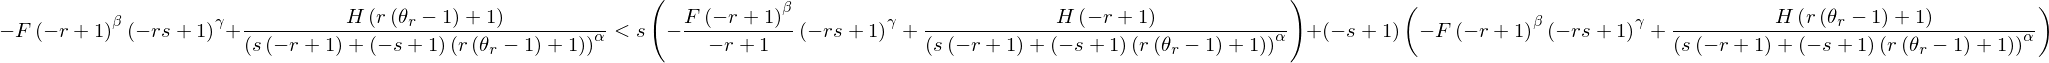

In [30]:
tools.utility(0, s) < tools.utility(s, s)

In [31]:
def evolutionary_stability(s, r_val=0.97, gamma_num=gamma_num, beta_num=beta_num, 
                           alpha_num=alpha_num, theta_r_num=theta_r_num, 
                           F_num=F_num, H_num=H_num,
                           tol=0.000001, step=0.0000001, starting_epsilon=0.00001):
    
    variables = {gamma: gamma_num, beta: beta_num, alpha: alpha_num, theta_r:theta_r_num, 
                 F: F_num, H: H_num, r:r_val}
    
    epsilon = starting_epsilon 
    
    evol_stable = []
    while epsilon > tol:
        
        up_s, down_s = min(s + epsilon, 1), max(s - epsilon, 0)
        delta_plus = (tools.utility(s, up_s) - tools.utility(up_s, up_s)).subs(variables)
        delta_minus = (tools.utility(s, down_s) - tools.utility(down_s, down_s)).subs(variables)
        
        evol_stable.append((delta_plus > tol) and (delta_minus > tol))
        epsilon -= step 
    
    return evol_stable, evol_stable[-1]

% Function with the condition of stability 

In [32]:
evolutionary_stability(1, step=0.001, tol=0.00001, starting_epsilon=0.1)

In [33]:
tools.evolutionary_stability(1, step=0.001, tol=0.00001, starting_epsilon=0.1)

Evolutionary stuff from Vince's course
-----------------------

In [34]:
def dx(x, t, A):
    """
    Define the derivate of x
    """
    f =  np.dot(A, x)
    phi = np.dot(f, x)
    
    return x * (f - phi)

In [35]:
epsilon = 10 ** -1

In [40]:
a_u = sym.lambdify((F, H, r, alpha, beta, gamma), 
                   tools.utility(1, 1, F=F, H=H, r=r,
                                 alpha=alpha, beta=beta, gamma=gamma))
b_u = sym.lambdify((F, H, r, alpha, beta, gamma, theta_r), 
                   tools.utility(1, 0, F=F, H=H, r=r,
                                 alpha=alpha, beta=beta, gamma=gamma, theta_r=theta_r))
c_u = sym.lambdify((F, H, r, alpha, beta, gamma, theta_r), 
                   tools.utility(0, 1, F=F, H=H, r=r,
                                 alpha=alpha, beta=beta, gamma=gamma, theta_r=theta_r))
d_u = sym.lambdify((F, H, r, alpha, beta, gamma, theta_r), 
                   tools.utility(0, 0, F=F, H=H, r=r,
                                 alpha=alpha, beta=beta, gamma=gamma, theta_r=theta_r))

In [41]:
B = np.array([[a_u(5, 10, 0.6, 0.95, 0.95, 0.95), b_u(5, 10, 0.6, 0.95, 0.95, 0.95, 0.2)], 
              [c_u(5, 10, 0.6, 0.95, 0.95, 0.95, 0.2), d_u(5, 10, 0.6, 0.95, 0.95, 0.95, 0.2)]])

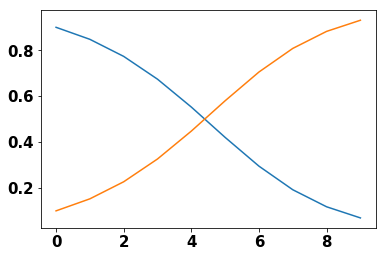

In [43]:
xs = odeint(func=dx, y0=[1 - epsilon, epsilon], t=rs, args=(B,))
plt.plot(xs);

In [ ]:
for params in itertools.product(Fs, Hs, rs, alphas, betas, gammas, theta_rs):
    F, H, r, alpha, beta, gamma, theta_r = params
    
    a_val = a_u(F, H, r, alpha, beta, gamma)
    b_val = b_u(F, H, r, alpha, beta, gamma, theta_r)
    c_val = c_u(F, H, r, alpha, beta, gamma, theta_r)
    d_val = d_u(F, H, r, alpha, beta, gamma, theta_r)
    
#     if a_val > c_val:
#         print(params)
#     elif a_val == c_val and b_val > d_val:
#         print(params)
    if a_val < c_val or (a_val == c_val and b_val < d_val):
        B = np.array([[a_val, b_val], 
                      [c_val, d_val]])
        plt.figure()
        xs = odeint(func=dx, y0=[1 - epsilon, epsilon], t=t, args=(B,))
        plt.plot(xs);
        plt.savefig('images/{}.pdf'.format(params))